# Word2Vec 를 통한 위픽 개인화 테스트



In [1]:
import requests
import time
import urllib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json
import elasticsearch
import csv
import pickle
from elasticsearch.helpers import bulk
import re
import glob
import os
from datetime import timezone, timedelta, datetime
from pymongo import MongoClient
import pymongo
import pandas as pd
import numpy as np
from operator import itemgetter

In [2]:
path = 'c:\\windows\\fonts\\nanumgothiccoding.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
### Jangmin's PC
es_url = 'localhost:9200'

### spark
es_catetory = elasticsearch.Elasticsearch('twiceSpark1:9200')

In [4]:
es = elasticsearch.Elasticsearch(es_url)

### wepick_setting data

- 4월 11일의 위픽으로 클릭받은 딜들 (397개)

In [5]:
with open(r'wepick_setting.pkl', 'rb') as f:
    wepick_dids = pickle.load(f)

## ES 관련 루틴


In [6]:
def es_category_search(deal_ids):
    """
    twiceSpark1의 elasticsearch의 ojm5 인덱스에서 딜-쿼리 가져옴
    """
    res = es_catetory.search(index='ojm5', body={'query': {'ids':{'values':deal_ids}}}, size=100)
    n = res['hits']['total']
    dic = {}
    for hit in res['hits']['hits']:
        dic[hit['_id']] =  hit['_source']
    return dic

In [7]:
def es_search_dids_for_user(user_id, day_limit):
    """
    user_id의 모든 v 가져오기
    day_limit 이전 것만 가져온다.
    return
    - 1st: v의 set
    - 2nd: 확장 정보 (v, rgtime, slot)
    """
    res = es.search(index='wepick_seq', 
                body={
                  "query": {
                    "bool": {
                      "must": { 
                        "term": {"u":user_id}
                      },
                      "filter": {
                        "range" : {
                          "rgtime" : {
                          "lt" : day_limit
                          }
                        }
                      }
                    }
                  },
                  "size": 64,
                  "sort": {"rgtime":"desc"}
                                }
               )
    if res['hits']['total'] > 0:
        until_dt = pd.to_datetime(day_limit).to_pydatetime()
        filtered = []
        for hit in res['hits']['hits']:
            filtered.append((hit['_source']['v'], hit['_source']['rgtime'], hit['_source']['slot']))
        return set(map(lambda x: x[0], filtered)), filtered
    return None, None

In [8]:
def es_gather_word2vec_dids(dids):
    """
    dids로부터, word2vec을 모은다.
    - 모아서, average pooling 실시
    return
    - vector normalized by L2-norm
    """
    res = es.search(index='deal_word2vec', 
                body={
                    'from':0, 'size': len(dids),
                    "_source": ["values"],
                    'query': {
                        'ids': {'values': dids }
                        }                        
                    }
               )
    mat = []
    for hit in res['hits']['hits']:
        vec = np.array(hit['_source']['values'])
        if len(vec) > 0:
            mat.append(vec)
    vec = np.mean(np.vstack(mat), axis=0)
    vec /= np.sqrt(np.sum(vec**2))
    return vec


In [9]:
def es_gather_word2vec_wepick(dids):
    """
    dids로부터, word2vec을 모은다.
    return
    - dids: unit-length w2v (normalized by L2-norm)
    """
    res = es.search(index='deal_word2vec', 
                body={
                    'from':0, 'size': len(dids),
                    "_source": ["values", "v"],
                    'query': {
                        'ids': {'values': dids }
                        }                        
                    }
               )
    dic = {}
    for hit in res['hits']['hits']:
        did = hit['_source']['v']
        vec = np.array(hit['_source']['values'])
        if len(vec) > 0:
            vec /= np.sqrt(np.sum(vec**2))
            dic[did] = vec
    return dic


### plot 관련

In [10]:
def show_one(arch, pred_list):
    """
    최대 다섯개만 보여준다.
    """
    img_base_url=r'http://img.wemep.co.kr/'
    
    fig, axes = plt.subplots(ncols=5, figsize=(16,16))    
    s = []
    for i, h in enumerate(pred_list):
        if i == 5: break
        f = urllib.request.urlopen(img_base_url+h[5])
        a = plt.imread(f, format='jpg')
        axes[i].imshow(a)
        s.append("{}/{}".format(h[2], h[3]))
        axes[i].set_title("{}[{}][{}]".format(i, h[1], h[3]))
        axes[i].axis('off')
    print("{}: {}".format(arch, ",".join(s)))
    plt.show()

In [11]:
def analyze_preds(search_results):
    img_base_url=r'http://img.wemep.co.kr/'
    
    candidates = list(map(lambda x: x[1], search_results))
    res = es_category_search(candidates)
    out=[]
    for prob, prod, _, _ in search_results:
        prod=str(prod)
        if prod in res:
            cat = res[prod]['_4']['_5']
            title = res[prod]['_2']
            img = res[prod]['_3']
            out.append((prod, 0, prob, cat, title, img))
#         else:
#             print("not found...{}".format(prod))
    show_one("", out)

### 3월 11 -  4월 10일까지 위픽 클릭 데이터에 대해 구성한 user_profile에 대한 테스트

In [12]:
def calc_rank(user_profile, deal_profile_dic):
    """
    user_profile, deal_profile의 inner product를 통한 점수 계산 및 정렬 (내림차순)
    """
    scores = []
    for did, deal_profile in deal_profile_dic.items():
        scores.append((did, np.inner(user_profile, deal_profile)))
    return sorted(scores, key=itemgetter(1), reverse=True)

In [13]:
def es_scan_extra_by_dids(dids):
    """
    dids로부터, mn, tn1를 가져온다.
    """
    res = es.search(index='dealinfos', 
                body={
                    'from':0, 'size': len(dids),
                    "_source": ["mn", "tn1", "did"],
                    'query': {
                        'ids': {'values': dids }
                        }                        
                    }
               )
    dic = {}
    for hit in res['hits']['hits']:
        dic[hit['_source']['did']] = (hit['_source']['mn'], hit['_source']['tn1'])
    return dic

In [14]:
# 위픽에 노출된 딜들에 대한 deal_profile을 생성 (2018-04-11)
deal_profile_dic = es_gather_word2vec_wepick(wepick_dids)

In [15]:
deals_user_viewed, ex = es_search_dids_for_user(1000007, '2018-04-11')

In [16]:
user_profile = es_gather_word2vec_dids(list(deals_user_viewed))

In [17]:
scores = calc_rank(user_profile, deal_profile_dic)

In [18]:
extra_dic = es_scan_extra_by_dids(wepick_dids)

In [19]:
def get_refined_scores(scores, extra_dic):
    refined_scores = []
    for did, score in scores:
        if did in extra_dic:
            refined_scores.append((score, did, extra_dic[did][0], extra_dic[did][1]))
        else:
            refined_scores.append((score, did, "", ""))
    return refined_scores

In [20]:
out = get_refined_scores(scores, extra_dic)

: 0.6923529276808937/원피스,0.6907389421700527/자켓/코트,0.684643460456734/티셔츠,0.6571769668608711/원피스,0.6503196405937113/티셔츠


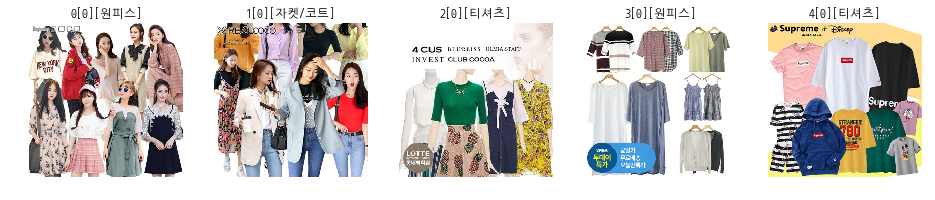

In [21]:
analyze_preds(out)

In [22]:
out

[(0.7031807779451916, 3480708, '[원더쿠폰] 원피스/블라우스/롱치마', '원피스'),
 (0.695728969587653, 3535398, '[무료배송] 원피스/블라우스/자켓', '원피스'),
 (0.6923529276808937, 3513258, '[무료배송] 원피스/블라우스/쟈켓', '원피스'),
 (0.6907389421700527, 3514389, '[무료배송] 트렌치코트/원피스/팬츠', '자켓/코트'),
 (0.684643460456734, 3525500, '[하객패션] 포커스 봄구성완벽해', '티셔츠'),
 (0.6726848766056309, 3512009, '[원더쿠폰] 첼로걸, 20%할인 쿠폰', '블라우스'),
 (0.6701652648613353, 3514028, '[롯데] 반할걸?반에이크+20%', '원피스'),
 (0.6680008048402479, 3516557, '[하객패션] 원피스/블라우스/티셔츠', '블라우스'),
 (0.6571769668608711, 3527477, '[투데이특가] 니트/가디건/원피스 외', '원피스'),
 (0.6561410326255429, 3525364, '[무료배송] 봄자켓/블라우스/원피스', '자켓/코트'),
 (0.6548876491708936, 3509158, '[원더쿠폰] 원피스/세트 파격+20%', '원피스'),
 (0.6546815714298577, 3515524, '[무료배송] 롱티/티셔츠/원피스', '티셔츠'),
 (0.6503196405937113, 3513523, '[원더쿠폰] 반팔티/맨투맨/후드티', '티셔츠'),
 (0.64893151009352, 3510881, '[원더쿠폰] 츄러블 ~20%쿠폰할인', '블라우스'),
 (0.6480349637797737, 3515712, '[무료배송] 데일리샵 ~20%할인쿠폰', '원피스'),
 (0.6434395078625526, 3503371, '[하객패션] 블라우스/원피스/가디건', '원피스'),
 (0.642061

### mongoDB for ActionInfos2

In [23]:
client = MongoClient(host='35.190.239.204', port=27017, username='praha_read', password='praha!@#', authSource='praha')

db = client['praha']

col = db['memberActionInfos2']

In [24]:
def mg_get_ordered_dids(mid, lt_day="20180411", limit=32):
    """
    구매한 딜들을 조회
    """
    result = col.find({"mid":mid, 'ft.o':{"$ne":[]}, 'day':{"$lt":lt_day}}, {'day':1, 'ft.o': 1, '_id':0}).sort('day', pymongo.DESCENDING).limit(limit)
    out = set()
    for res in result:
        out.update(list(map(lambda x: x['did'], res['ft']['o'])))
    return out

In [25]:
def mg_get_clicked_dids(mid, lt_day="20180411", limit=32, use_search_induced_click=False):
    """
    클릭한 딜들을 조회
    """
    result = col.find({"mid":mid, 'ft.c':{"$ne":[]}, 'day':{"$lt":lt_day}}, {'day':1, 'ft.c': 1, '_id':0}).sort('day', pymongo.DESCENDING).limit(limit)
    out = set()
    for res in result:
        out.update(list(map(lambda x: x['did'], 
                            res['ft']['c'] if use_search_induced_click == False else filter(lambda x: x['s'] != '', res['ft']['c'])
                           )))
    return out

### 구매 did로 부터 랭킹 테스트

- 구매 did 들의 word2vec을 사용

In [26]:
dids = mg_get_ordered_dids(1000007, limit=32)

In [27]:
user_profile = es_gather_word2vec_dids(list(dids))

In [28]:
scores = calc_rank(user_profile, deal_profile_dic)

In [29]:
out = get_refined_scores(scores, extra_dic)

: 0.4362735454799641/여성단화,0.38126678874137565/티셔츠,0.3710023554263202/캡슐커피/티백커피,0.36100201427878925/아동공용의류,0.3404301219003032/건강관리


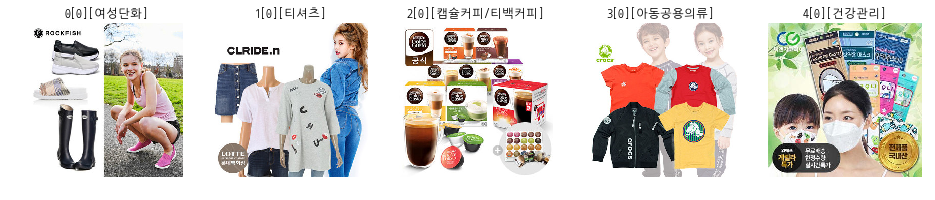

In [30]:
analyze_preds(out)

In [31]:
out

[(0.492450621211873, 3521090, '[어린이날] 인기 브랜드슈즈 파격가!', '유아동신발'),
 (0.49031390761747407, 3522990, '[무료배송] 매장판 아디다스 102종', '런닝화/운동화 기타'),
 (0.4877449240708161, 3512477, '[어린이날] 아디다스外 아동 20%쿠폰', '유아동신발'),
 (0.4877028264060962, 3515664, '[무료배송] 뉴발란스/아디다스外', '런닝화'),
 (0.4499051740205957, 3506322, '[원더쿠폰] 구두/신발/+20%쿠폰', '여성단화'),
 (0.4393488900094547, 3499106, '[하객패션] 신상 로퍼/구두+원더쿠폰', '펌프스/하이힐'),
 (0.4362735454799641, 3529165, '[하객패션] 락피쉬 18년S/S+20%쿠폰!', '여성단화'),
 (0.42313187117899387, 3512078, '[무료배송] 빅브랜드 역대급 295종', '런닝화/운동화 기타'),
 (0.4197281659440646, 3489226, '[어린이날] 나이키X크록스 가격인하!', '유아동신발'),
 (0.40355871994382464, 3518662, '[롯데] 소보제화 HOT 슈즈 69종!', '여성단화'),
 (0.40274434185613733, 3509504, '[원더쿠폰] 봄신상 여성구두 20%쿠폰', '펌프스/하이힐'),
 (0.4013526893444316, 3513027, '[원더쿠폰] 신발/구두/운동화20%쿠폰', '펌프스/하이힐'),
 (0.39178555386983765, 3522395, '[롯데] 르까프 아동/성인 빅세일', '남성 티셔츠/상의 기타'),
 (0.38126678874137565, 3509271, '[롯데] 클라이드 현아 Pick!', '티셔츠'),
 (0.378283571150055, 3524297, '[심야특가] 신발/운동화/구두/슬립온', '가보시/웨지힐/통굽'),


### 클릭 did로 부터 랭킹 테스트

- 유저가 클릭한 did 들의 word2vec을 사용
- use_search_induced_click==True 면, 검색후 클릭된 did만 가져온다.

In [32]:
dids= mg_get_clicked_dids(1000007, limit=64, use_search_induced_click=True)

In [33]:
user_profile = es_gather_word2vec_dids(list(dids))

In [34]:
scores = calc_rank(user_profile, deal_profile_dic)

In [35]:
out = get_refined_scores(scores, extra_dic)

: 0.3606081925550658/귀걸이,0.34489640096640195/노트북 38cm 이상,0.2800387218250157/노트북 38cm 이상,0.2792941015100814/팩/마스크,0.27661478059455213/스킨/로션


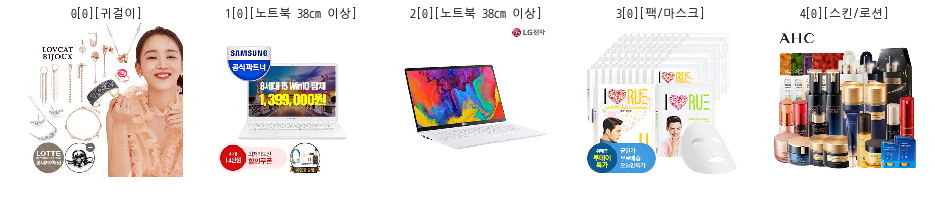

In [36]:
analyze_preds(out)

In [37]:
out

[(0.44189338115853305, 3506674, '[투데이특가] 라피타 IPL 레이저', '제모기'),
 (0.39164051695433766, 3207879, '[9만쿠폰] LG올뉴그램 15ZD980-GX5BK', '노트북 38cm 이상'),
 (0.39132290041130346, 3499593, '[투데이특가] HP 코어i5 SSD노트북', '중고/리퍼/반품/전시'),
 (0.3606081925550658, 3513720, '[하객패션] 러브캣비쥬ACC + 20%쿠폰', '귀걸이'),
 (0.34607979769715047, 3506322, '[원더쿠폰] 구두/신발/+20%쿠폰', '여성단화'),
 (0.34489640096640195,
  3238108,
  '[삼성] 노트북9Always NT900X5T-K58A',
  '노트북 38cm 이상'),
 (0.3306901000039108, 3508410, '[게릴라특가] KF94/80 황사마스크', '건강관리'),
 (0.3257723875540223, 3518662, '[롯데] 소보제화 HOT 슈즈 69종!', '여성단화'),
 (0.31901082371107337, 3522990, '[무료배송] 매장판 아디다스 102종', '런닝화/운동화 기타'),
 (0.31721299897682326, 3524297, '[심야특가] 신발/운동화/구두/슬립온', '가보시/웨지힐/통굽'),
 (0.30847923309904346, 3499106, '[하객패션] 신상 로퍼/구두+원더쿠폰', '펌프스/하이힐'),
 (0.3084274977783398, 3509504, '[원더쿠폰] 봄신상 여성구두 20%쿠폰', '펌프스/하이힐'),
 (0.29677160462893826, 3512477, '[어린이날] 아디다스外 아동 20%쿠폰', '유아동신발'),
 (0.29269815558402185, 3515664, '[무료배송] 뉴발란스/아디다스外', '런닝화'),
 (0.2800387218250157, 3513276, 